# Imports and Hyperparameters

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT, compute_widths
from External.clustering import k_means_pp, centers
from External.generation import create_graph
from External.plotting import plot_points, plot_graph, no_intersections
from External.data_loader import data_loader
from External.ICT.reduce_to_mst import MST

plt.style.use('standard.mplstyle')

cv2 package not present. No movies possible


In [5]:
# Hyperparameters
mode = "K_Nearest+Density2"
metric = "euclidean"
dataset = "eth_CA"

# for the filename
parameters = "2-0_5-exact"

# Data Preperation

In [6]:
start = time.time()

# load the dataset & UMAP embedding (if dim > 2)
position, labels, embedding = data_loader(dataset, True)
# calculate the clusters
if len(position[0]) > 500:
    pca = PCA(n_components=100).fit_transform(StandardScaler().fit_transform(position))
else:
    pca = StandardScaler().fit_transform(position)
cluster_centers = centers(pca)
# Save the number of nodes (sometimes needed)
number_of_nodes = len(position)

print("Time for data preperation: ", time.time()-start)

sklearn is done: 22.584227561950684
My own part is done: 1.4597554206848145
Time for data preperation:  113.26746010780334


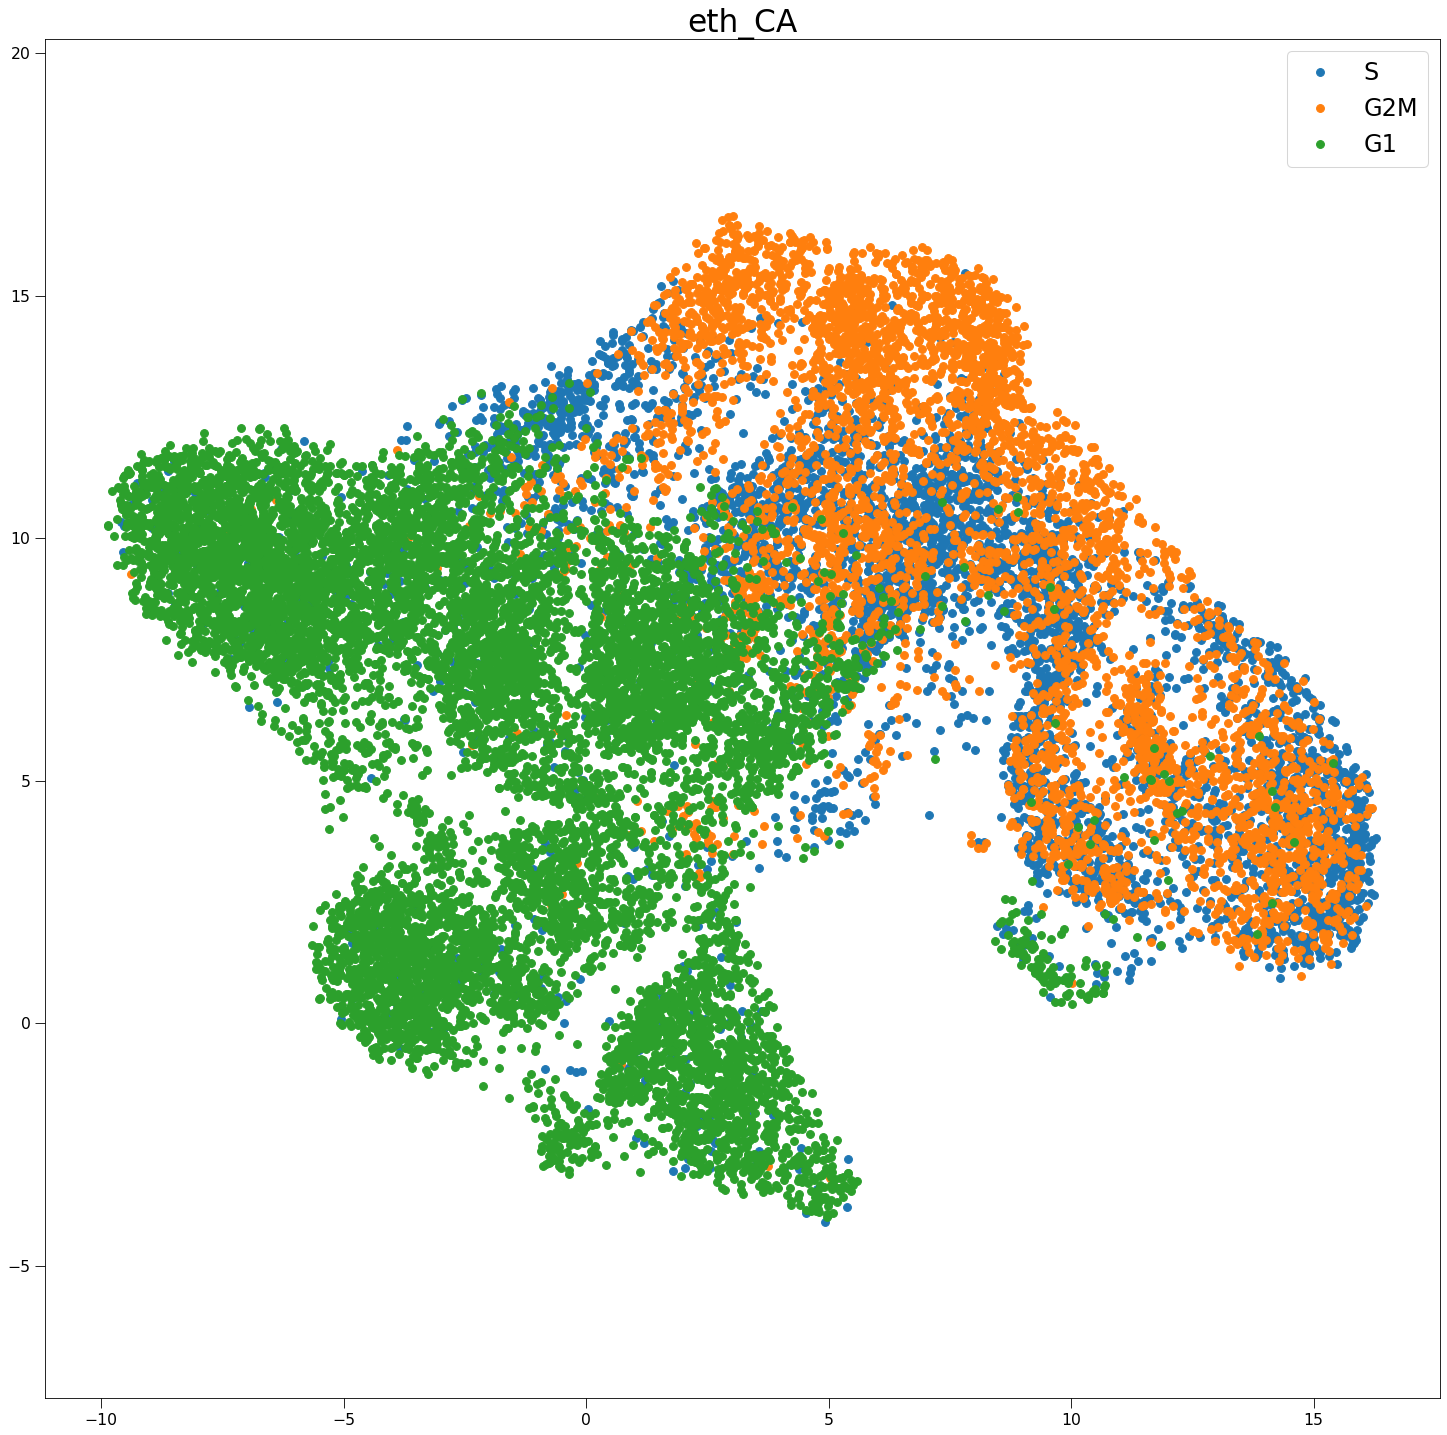

In [7]:
fig, ax = plt.subplots(1, figsize=(24,24))
plot_points(embedding, dataset, ax, labels)
plt.show()

In [8]:
# Create the graph
start = time.time()
    
G, _ = create_graph(number_of_nodes, mode, position=pca, beta=2, delta=0.5)
G.indexEdges()
print("Time for graph construction: ",time.time()-start)

Final k: 11


calculating the densities for the density criterion:   0%|          | 0/19029 [00:00<?, ?it/s]

updating the weights:   0%|          | 0/184938 [00:00<?, ?it/s]

Time for graph construction:  166.09827733039856


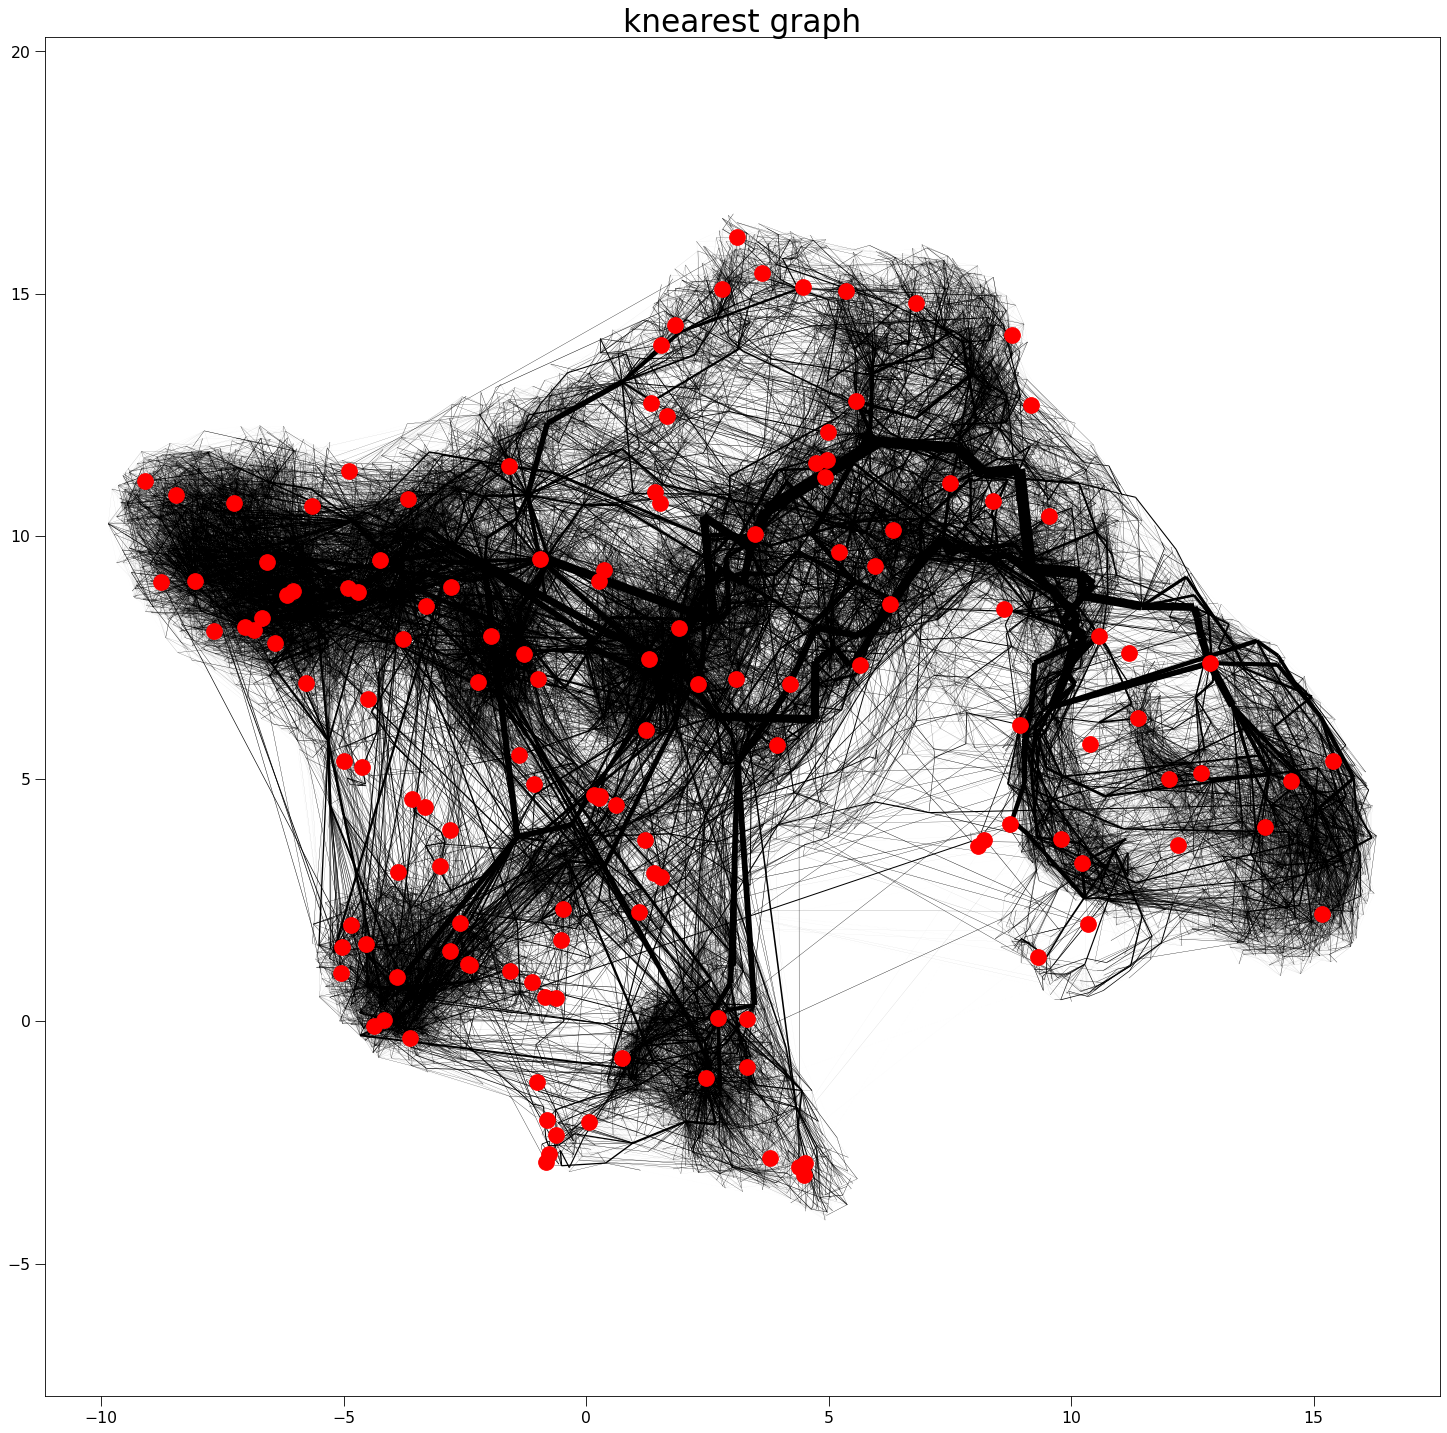

In [9]:
# plot the graph
fig, ax = plt.subplots(1, figsize=(24,24))
plot_graph(G, embedding, "knearest graph", ax, cluster_centers, node_size=0)
plt.show()

## Cluster ICT

In [ ]:
# calculate the cluster ICT with all aim nodes
start = time.time()
ICT = calculate_ICT(G, algorithm_type="exact_own", cluster_centers=cluster_centers,
                                zeros_stay_zeros=True, update_G=1.1)
ICT.indexEdges()
print("Time for calculating the actual ICT: ", time.time()-start)

create edgeId array:   0%|          | 0/184938 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/184938 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/19028 [00:00<?, ?it/s]

update Arr 184938 -> 130631
added 250 edges early
update Arr 130631 -> 118645
added 29 edges early
update Arr 118645 -> 107857
added 50 edges early
update Arr 107857 -> 98018
added 61 edges early
update Arr 98018 -> 89091
added 80 edges early
update Arr 89091 -> 80968
added 121 edges early
update Arr 80968 -> 73602
added 208 edges early
update Arr 73602 -> 66894
added 146 edges early
update Arr 66894 -> 60787
added 113 edges early


In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))

plot_graph(ICT, embedding, "ICT (UMAP)", ax1, cluster_centers, node_size=0)
plot_points(embedding, "Ground truth", ax2, labels)

plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-UMAP-"+parameters+".png")

plt.show()

In [ ]:
if (dataset == "pancreas_reduced") or (dataset == "pancreas_full") or (dataset=="eth_CC"):
    if dataset == "pancreas_reduced":
        dtae_embedding, dtae_labels = data_loader("pancreas_reduced_DTAE_embedding")
        
    elif dataset == "pancreas_full":
        dtae_embedding, dtae_labels = data_loader("pancreas_full_DTAE_embedding")
        
    elif dataset=="eth_CC":
        dtae_embedding, dtae_labels = data_loader("CC_DTAE_embedding")
    
    else:
        raise RuntimeError("Something went definitively wrong!?")
        
        
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))
    plot_graph(ICT, dtae_embedding, "ICT (DTAE)", ax1, cluster_centers, node_size=0)
    plot_points(dtae_embedding, "Ground truth", ax2, dtae_labels)
    
    if dataset == "eth_CC":
        ax1.set_xlim([-50,60])
        ax2.set_xlim([-50,60])
        ax1.set_ylim([-45,50])
        ax2.set_ylim([-45,50])
    
    plt.tight_layout()
    plt.savefig("./Output/Images/"+dataset+"-DTAE-"+parameters+".png")
    plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(24,24))
no_intersections(ICT, embedding, ax, labels)
plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-no-intersection-"+parameters+".png")
plt.show()

# Create the MST for the DTAE autoencoder

In [ ]:
nk.writeGraph(ICT,"/net/hcihome/storage/flernst/Data/eth/ICT", nk.Format.EdgeListTabOne)

In [ ]:
DTAE_centers = k_means_pp(50, pca)
mst = MST(ICT, position, DTAE_centers)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))
plot_graph(ICT, embedding, "ICT (UMAP)", ax1, DTAE_centers, edge_scale=0.3)
plot_graph(mst, embedding[DTAE_centers], "MST (UMAP)", ax1, edge_scale=2, node_size=0, edge_color="green")
plot_points(embedding, "Ground truth", ax2, labels)

plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-MST-"+parameters+".png")

plt.show()

In [ ]:
DTAE_centers, DTAE_labels = k_means_pp(150, pca, return_labels=True)
unique_DTAE_labels = np.unique(DTAE_labels)

components = []
node_labels = [None for _ in range(number_of_nodes)]
for label in np.sort(unique_DTAE_labels):
    component = np.argwhere(label == DTAE_labels).T
    assert len(component) == 1
    
    for node in component[0]:
        node_labels[node] = label
        
    components.append(component[0].tolist())
removal = []
for idx, component in enumerate(components):
    if len(component) < 5:
        removal.append(idx)
        
DTAE_centers = np.delete(DTAE_centers, removal)

mst = MST(ICT, position, DTAE_centers)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))
plot_graph(ICT, embedding, "ICT (UMAP)", ax1, DTAE_centers, edge_scale=0.3)
plot_graph(mst, embedding[DTAE_centers], "MST (UMAP)", ax1, edge_scale=2, node_size=0, edge_color="green")
plot_graph(ICT, embedding, "ICT (UMAP)", ax2, cluster_centers, node_size=0)

plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-MST-"+parameters+ "-removed-clusters" + ".png")

plt.show()